<a href="https://colab.research.google.com/github/SaadIqbalGH/Deep-Learning-CNN-Transfer-Learning/blob/main/DCGAN_Anime_TensorflowRef1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!mkdir dcgan

In [5]:
!mkdir dcgan/tf

In [6]:
!mkdir dcgan/tf/images

In [7]:
!mkdir dcgan/tf/training_checkpoints

In [8]:
#import the required packages
import os
import time
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
img_height, img_width = 64, 64
batch_size = 128

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/MyDrive/Colab Notebooks/Anime_Faces',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

Found 21571 files belonging to 1 classes.


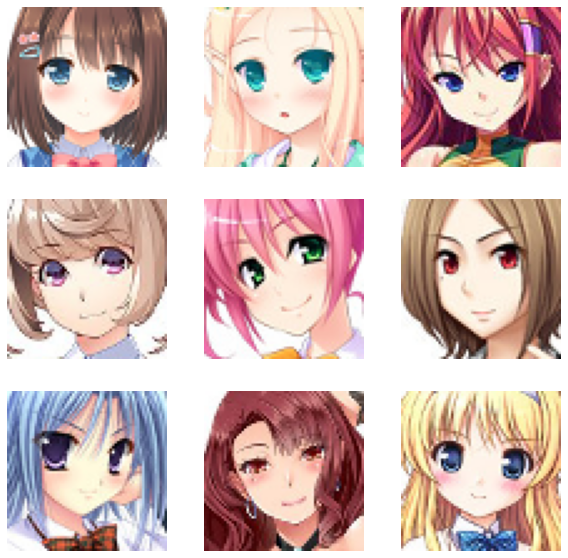

In [11]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [12]:
for image_batch in train_ds:
  print(image_batch.shape)
  break

(128, 64, 64, 3)


In [13]:
tf.data.experimental.AUTOTUNE

-1

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./127.5, offset=-1)

In [16]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 

-1.0 1.0


In [17]:
noise_dim = (1,1,100)

In [40]:
def generator():
    
    inputs = keras.Input(shape=(1, 1, 100), name='input_layer')
    x = layers.Conv2DTranspose(64 * 8, kernel_size=4, strides= 4, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1')(inputs)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.ReLU(name='relu_1')(x)
    
    x = layers.Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.ReLU(name='relu_2')(x)
    
    x = layers.Conv2DTranspose(64 * 2, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3')(x)
    x = layers.ReLU(name='relu_3')(x)
  

    x = layers.Conv2DTranspose(64 * 1, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4')(x)
    x = layers.ReLU(name='relu_4')(x)
    
    outputs = layers.Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, activation='tanh', name='conv_transpose_5')(x)
   
    model = tf.keras.Model(inputs, outputs, name="Generator")
    return model

In [41]:
generator = generator()

In [42]:
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 1, 100)]       0         
_________________________________________________________________
conv_transpose_1 (Conv2DTran (None, 4, 4, 512)         819200    
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 4, 4, 512)         2048      
_________________________________________________________________
relu_1 (ReLU)                (None, 4, 4, 512)         0         
_________________________________________________________________
conv_transpose_2 (Conv2DTran (None, 8, 8, 256)         2097152   
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 8, 8, 256)         1024      
_________________________________________________________________
relu_2 (ReLU)                (None, 8, 8, 256)         0 

In [43]:
generator.save('dcgan_gen.h5')

In [44]:
def discriminator():
    
    inputs = keras.Input(shape=(64, 64, 3), name='input_layer')
    x = layers.Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_1')(inputs)
    x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
    
    x = layers.Conv2D(64 * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_2')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
    
    x = layers.Conv2D(64 * 4, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_3')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_3')(x)
  

    x = layers.Conv2D(64 * 8, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_4')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_3')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_4')(x)
    
    outputs = layers.Conv2D(1, 4, 4,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, activation='sigmoid', name='conv_5')(x)
    
    outputs = layers.Flatten()(outputs)
   
    model = tf.keras.Model(inputs, outputs, name="Discriminator")
    return model

In [45]:
discriminator = discriminator()

In [46]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 32, 32, 64)        3072      
_________________________________________________________________
leaky_relu_1 (LeakyReLU)     (None, 32, 32, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 128)       131072    
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_relu_2 (LeakyReLU)     (None, 16, 16, 128)       0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 8, 8, 256)       

In [47]:
discriminator.save('dcgan_disc.h5')

In [48]:
BATCH_SIZE=128
latent_dim = 100

In [49]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [50]:
def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    #print(gen_loss)
    return gen_loss

In [51]:
def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    #print(total_loss)
    return disc_loss

In [52]:
learning_rate = 0.0002 
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

In [53]:
num_examples_to_generate = 25
# We will reuse this seed overtime to visualize progress
seed = tf.random.normal([num_examples_to_generate, 1, 1, latent_dim])

In [54]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # noise vector sampled from normal distribution
    noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])

    # Train Discriminator with real labels
    with tf.GradientTape() as disc_tape1:
        generated_images = generator(noise, training=True)

        
        real_output = discriminator(images, training=True)
        real_targets = tf.ones_like(real_output)
        disc_loss1 = discriminator_loss(real_targets, real_output)
        
    # gradient calculation for discriminator for real labels    
    gradients_of_disc1 = disc_tape1.gradient(disc_loss1, discriminator.trainable_variables)
    
    # parameters optimization for discriminator for real labels   
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc1,\
    discriminator.trainable_variables))
    
    # Train Discriminator with fake labels
    with tf.GradientTape() as disc_tape2:
        fake_output = discriminator(generated_images, training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = discriminator_loss(fake_targets, fake_output)
    # gradient calculation for discriminator for fake labels 
    gradients_of_disc2 = disc_tape2.gradient(disc_loss2, discriminator.trainable_variables)
    
    
    # parameters optimization for discriminator for fake labels        
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc2,\
    discriminator.trainable_variables))
    
    # Train Generator with real labels
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)

    # gradient calculation for generator for real labels     
    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # parameters optimization for generator for real labels
    generator_optimizer.apply_gradients(zip(gradients_of_gen,\
    generator.trainable_variables))    

In [55]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        D_loss_list, G_loss_list = [], []
        for image_batch in dataset:
            i += 1
            train_step(image_batch)
        print(epoch)        
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                              epoch + 1,
                              seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            generator.save_weights('dcgan/tf/training_weights/gen_'+ str(epoch)+'.h5')
            discriminator.save_weights('dcgan/tf/training_weights/disc_'+ str(epoch)+'.h5')    
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)

In [56]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = (predictions[i, :, :, :] + 1 ) * 127.5
        pred = np.array(pred)  
        plt.imshow(pred.astype(np.uint8))
        plt.axis('off')

    plt.savefig('dcgan/tf/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

(25, 64, 64, 3)


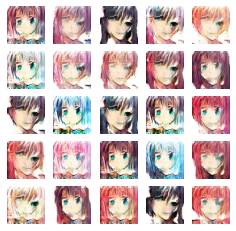

In [57]:
train(normalized_ds, 100)